In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from kAugmentations.kRotation import *
from kAugmentations.kBrightness import *
from kAugmentations.kShearX import *
from kAugmentations.kTranslateX import *
from kAugmentations.kContrast import *

from kAugmentations.kRandRotation import *

from wrappers import DUniform

from SingleAugmentationConfig import *
from MultiAugmentationManager import MultiAugmentationManager

import shutil

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

%matplotlib inline

/home/tom/anaconda3/envs/DADA/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configs

#### Brightness

In [2]:
# ### --- Config --- ###
# augmentation_name = 'brightness'
# main_parameter_name = 'brightness_factor'
# aug_bounds = (0.0, 1.0)
# param_linspace = np.linspace(aug_bounds[0],aug_bounds[1],400)

# # dataset
# target_param_val = .5
# target_aug_constructor = K.enhance.AdjustBrightness
# target_aug_constructor_args = {
#     'brightness_factor': target_param_val,
# }

# kAugmentation = kBrightness
# init_param_val = 0.

# # training
# criterion_constructor = nn.MSELoss
# criterion_constructor_args = {}

# batch_size = 64
# epochs = 1

# optimizer_constructor = optim.SGD
# optimizer_constructor_args = {
#     'lr': 0.01,
#     'momentum': 0.9,
# }

# scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
# scheduler_constructor_args = {
#     'T_max':100,
#     'eta_min':0.1,
#     'verbose':True,
# }

# scheduler_warmup = 100
# scheduler_freq = 10
# use_scheduler=False

# early_stopping = 500

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# # paths:
# run_name = f'{augmentation_name}-init-{init_param_val}_target-{target_param_val}'

# figures_dir = f'figures'
# run_figures_dir = f'{figures_dir}/{run_name}'

# gifs_dir = f'gifs'
# run_gif_name = f'{gifs_dir}/{run_name}.gif'

# os.makedirs(run_figures_dir, exist_ok=True)
# os.makedirs(gifs_dir, exist_ok=True)
# os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
# os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)


#### Rotation

In [3]:
### --- Config --- ###
augmentation_name = 'random-rotation'
main_parameter_name = 'angle'
aug_bounds = (-360., 360.)
param_linspace = np.linspace(aug_bounds[0],aug_bounds[1],400)

# dataset
target_param_bounds = (25.,50.)
target_aug_constructor = K.geometry.transform.Rotate
target_aug = DUniform(target_aug_constructor, bounds=target_param_bounds)

# target_param_val = (20.,30.)
# target_aug_constructor = K.augmentation.RandomRotation
# target_aug_constructor_args = {
#     'degrees': torch.Tensor(target_param_val),
#     'p': 1
# }
# target_aug = target_aug_constructor(**target_aug_constructor_args)


init_param_bounds = (-100.,100,)
kAugmentation = DUniform(kRotation, bounds=init_param_bounds)

# training
criterion_constructor = nn.MSELoss
criterion_constructor_args = {}

batch_size = 64
epochs = 1

optimizer_constructor = optim.SGD
optimizer_constructor_args = {
    'lr': 50,
    'momentum': 0.99,
}

scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
scheduler_constructor_args = {
    'T_max':100,
    'eta_min':0.1,
    'verbose':True,
}

scheduler_warmup = 200
scheduler_freq = 10
use_scheduler=True

early_stopping = 1200

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# paths:
run_name = f'{augmentation_name}-init-{init_param_bounds}_target-{target_param_bounds}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

#### ShearX

In [4]:
# ### --- Config --- ###
# augmentation_name = 'shearX'
# main_parameter_name = 'shear'
# aug_bounds = (None, None)
# param_linspace = np.linspace(-2,2,400)

# # dataset
# target_param_val = 0.4
# target_aug_constructor = K.geometry.transform.Shear
# target_aug_constructor_args = {
#     'shear': torch.Tensor([[target_param_val, 0]]),
# }

# kAugmentation = kShearX
# init_param_val = 0.0

# # training
# criterion_constructor = nn.MSELoss
# criterion_constructor_args = {}

# batch_size = 64
# epochs = 1

# optimizer_constructor = optim.SGD
# optimizer_constructor_args = {
#     'lr': 0.1,
#     'momentum': 0.9,
# }

# scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
# scheduler_constructor_args = {
#     'T_max':200,
#     'eta_min':0.1,
#     'verbose':True,
# }

# use_scheduler=True
# scheduler_warmup = 100
# scheduler_freq = 10


# early_stopping = 500

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# # paths:
# run_name = f'{augmentation_name}-init-{init_param_val}_target-{target_param_val}'

# figures_dir = f'figures'
# run_figures_dir = f'{figures_dir}/{run_name}'

# gifs_dir = f'gifs'
# run_gif_name = f'{gifs_dir}/{run_name}.gif'

# os.makedirs(run_figures_dir, exist_ok=True)
# os.makedirs(gifs_dir, exist_ok=True)
# os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
# os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

#### TranslateX

In [5]:
# ### --- Config --- ###
# augmentation_name = 'translateX'
# main_parameter_name = 'translation'
# aug_bounds = (None, None)
# param_linspace = np.linspace(-100,100,400)

# # dataset
# target_param_val = 20.0
# target_aug_constructor = K.geometry.transform.Translate
# target_aug_constructor_args = {
#     'translation': torch.Tensor([[target_param_val, 0]]),
# }

# kAugmentation = kTranslateX
# init_param_val = 0.0

# # training
# criterion_constructor = nn.MSELoss
# criterion_constructor_args = {}

# batch_size = 64
# epochs = 1

# optimizer_constructor = optim.SGD
# optimizer_constructor_args = {
#     'lr': 100,
#     'momentum': 0.7,
# }

# scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
# scheduler_constructor_args = {
#     'T_max':200,
#     'eta_min':0.1,
#     'verbose':True,
# }

# use_scheduler=True
# scheduler_warmup = 0
# scheduler_freq = 10


# early_stopping = 250

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# # paths:
# run_name = f'{augmentation_name}-init-{init_param_val}_target-{target_param_val}'

# figures_dir = f'figures'
# run_figures_dir = f'{figures_dir}/{run_name}'

# gifs_dir = f'gifs'
# run_gif_name = f'{gifs_dir}/{run_name}.gif'

# os.makedirs(run_figures_dir, exist_ok=True)
# os.makedirs(gifs_dir, exist_ok=True)
# os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
# os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

#### Contrast

In [6]:
# ### --- Config --- ###
# augmentation_name = 'contrast'
# main_parameter_name = 'contrast_factor'
# aug_bounds = (0.0, None)
# param_linspace = np.linspace(0.0,10.,400)

# # dataset
# target_param_val = 3.
# target_aug_constructor = K.enhance.AdjustContrast
# target_aug_constructor_args = {
#     'contrast_factor': target_param_val,
# }

# kAugmentation = kContrast
# init_param_val = 1.

# # training
# optimizer_constructor = optim.SGD
# optimizer_constructor_args = {
#     'lr': 0.1,
#     'momentum': 0.9,
# }

# scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
# scheduler_constructor_args = {
#     'T_max':100,
#     'eta_min':0.1,
#     'verbose':True,
# }

# scheduler_warmup = 100
# scheduler_freq = 10
# use_scheduler=False

# early_stopping = 250

# batch_size = 64
# epochs = 1

# criterion_constructor = nn.MSELoss
# criterion_constructor_args = {}

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # paths:
# run_name = f'{augmentation_name}-init-{init_param_val}_target-{target_param_val}'

# figures_dir = f'figures'
# run_figures_dir = f'{figures_dir}/{run_name}'

# gifs_dir = f'gifs'
# run_gif_name = f'{gifs_dir}/{run_name}.gif'

# os.makedirs(run_figures_dir, exist_ok=True)
# os.makedirs(gifs_dir, exist_ok=True)
# os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
# os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

### Training:

In [7]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.container.ImageSequential(
        target_aug
    )
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

In [8]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

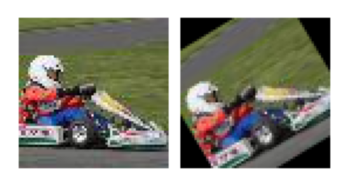

In [9]:
show_sample(dataset[0])

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [11]:
model = K.augmentation.ImageSequential(kAugmentation)
model.to(device)

ImageSequential(
  (DUniform_0): DUniform()
)

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

DUniform_0.learned_bounds tensor([-100.,  100.], device='cuda:0')


In [13]:
criterion = criterion_constructor(**criterion_constructor_args)
optimizer = optimizer_constructor(model.parameters(), **optimizer_constructor_args)
scheduler = scheduler_constructor(optimizer, **scheduler_constructor_args)

Adjusting learning rate of group 0 to 5.0000e+01.


In [14]:
with torch.no_grad():
    img_dict = {
        "source": dataset[0][0],
        "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
        "target": dataset[0][1]
    }
    learning_grid(img_dict, title=augmentation_name, save=f'{run_figures_dir}/learning_progress/epoch-{0:02}_batch-{0:05}.png')
    
param_progress = []
param_progress.append(model[0].get_param_val())

In [15]:
losses = []
lrs = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)

        #####################################
        entropy_lamda =  1e-2
        loss = criterion(output_images, target_images) - entropy_lamda * kAugmentation.get_entropy()
        # loss = criterion(output_images, target_images)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{main_parameter_name}: {model[0].get_param_val()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, title=augmentation_name, save=f'{run_figures_dir}/learning_progress/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        lrs.append(scheduler.get_last_lr())
        param_progress.append(model[0].get_param_val())
        if use_scheduler:
            if i % scheduler_freq == scheduler_freq - 1 and i > scheduler_warmup:
                scheduler.step()


        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.019 | angle: [-99.84226 102.56379]]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.013 | angle: [-99.4834  104.65922]]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.044 | angle: [-96.8199  103.18459]]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.025 | angle: [-92.62805 100.79165]]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.031 | angle: [-88.228134  97.52397 ]]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.021 | angle: [-83.96468  92.28062]]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.025 | angle: [-79.62177  86.68974]]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.019 | angle: [-74.188896  82.603264]]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.021 | angle: [-68.837524  78.77438 ]]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.018 | angle: [-62.39255  75.86407]]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.004 | angle: [-56.635387  70.01582 ]]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.015 | angle: [-51.234684  64.18964 ]]
[Epoch: 1 | Batch: 130 | MSE Loss: 0.015 | angle: [-45.712276  59.900166]]
[Epoch: 1 | Batch: 140 | MSE Loss: 0.022 | angle

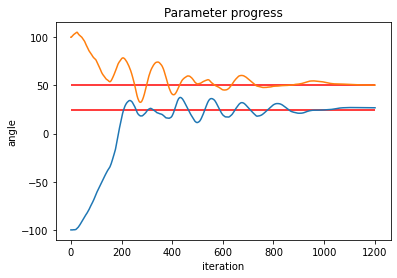

In [16]:
plt.plot(param_progress, zorder=7)
plt.hlines(y=target_param_bounds, xmin=0, xmax=[len(param_progress)], color='r',zorder=5)
plt.xlabel('iteration')
plt.ylabel(f'{main_parameter_name}')
plt.title('Parameter progress')
plt.savefig(f'{run_figures_dir}/results/parameter_progress__{main_parameter_name}.png')

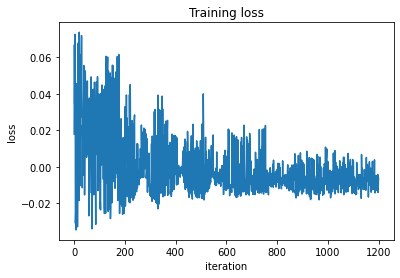

In [17]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

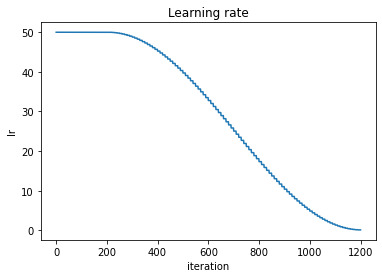

In [18]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [19]:
num_frames = 70
start_freeze_frames = 10
# filepaths
fp_in = f"{run_figures_dir}/learning_progress/epoch-*"
fp_out = run_gif_name

img_list = [Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames]
img_list = [img_list[0]]*start_freeze_frames + img_list
imgs = iter(img_list)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)

In [20]:
with torch.no_grad():
    param_losses = []
    for p in param_linspace:
        p_model = K.augmentation.ImageSequential(
            kAugmentation(init_param=p)
        )
        for i, data in enumerate(dataloader): # calc for one batch
            source_images, target_images = data
            source_images, target_images = source_images, target_images
            output_images = p_model(source_images)
            loss = criterion(output_images, target_images)
            param_losses.append(loss.item())
            break
    param_losses = np.array(param_losses)

param_progress_idxs = []
for p in param_progress:
    idx_dist = np.apply_along_axis(lambda idx: abs(idx - p), axis=0, arr=param_linspace)
    param_progress_idxs.append(np.argmin(idx_dist))

TypeError: forward() got an unexpected keyword argument 'init_param'

In [ ]:
idx_target_dist = np.apply_along_axis(lambda idx: abs(idx - target_param_val), axis=0, arr=param_linspace)
target_param_idx = np.argmin(idx_target_dist)

In [ ]:
plt.plot(param_linspace, param_losses, zorder=5)
plt.plot(param_linspace[param_progress_idxs], param_losses[param_progress_idxs], zorder=7)
plt.scatter(x=param_linspace[param_progress_idxs[0]],y=param_losses[param_progress_idxs[0]], marker='*', c='r', s=100, zorder=9)
plt.scatter(x=param_linspace[param_progress_idxs[-1]],y=param_losses[param_progress_idxs[-1]], marker='*', c='b', s=150, zorder=9)
plt.scatter(x=param_linspace[target_param_idx],y=param_losses[target_param_idx], marker='*', c='lime', s=50, zorder=10)
plt.savefig(f'{run_figures_dir}/results/loss_map.png')